# Libs

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn.linear_model import LinearRegression, PoissonRegressor, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from statsmodels.api import OLS, add_constant

from sklearn.base import BaseEstimator, TransformerMixin

import joblib

import warnings
warnings.filterwarnings("ignore")

# Data

In [11]:
df = pd.read_csv("./data/train.csv")
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# As time plays importatn tole
# we need to conver "datetime" column
# to timestamp and extract hour data

In [12]:
df["datetime"] = pd.to_datetime(df["datetime"])
df["hour"] = df["datetime"].dt.hour
df.set_index("datetime", inplace=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


# EDA

In [ ]:
# we can indeed see that
# there is repetative patterns
# in all seasons
# that confimrs relevence of "hour"
# which are different for working/non-workings

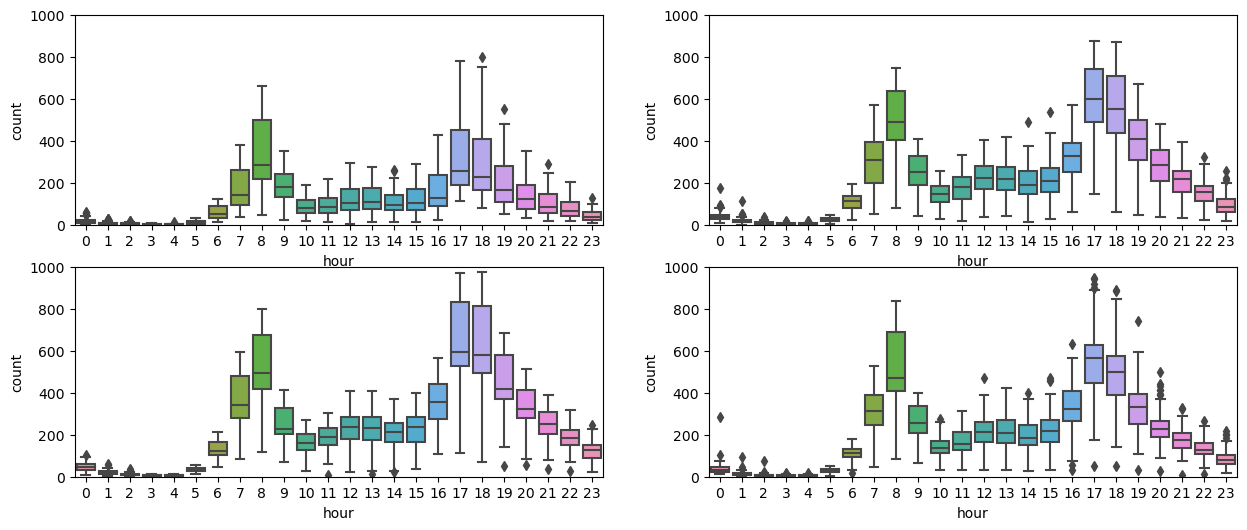

In [15]:
# Working days
fig = plt.figure(figsize=(15,6))

for season in df["season"].unique():
    plt.subplot(2,2,season)
    sns.boxplot(data = df[df["workingday"]==True][df["season"]==season], y="count", x="hour")
    plt.ylim(0,1000)

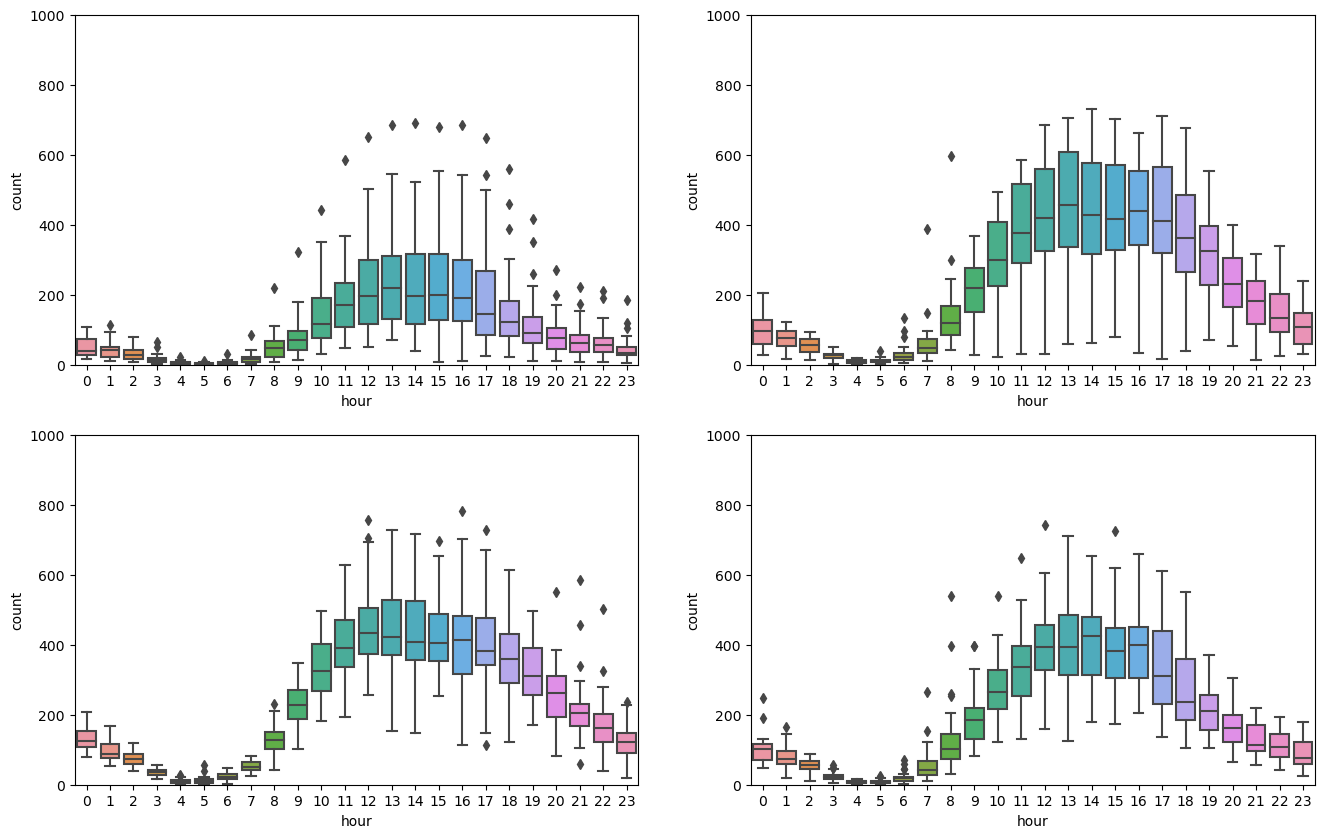

In [16]:
# Non-working days
fig = plt.figure(figsize=(16,10))

for season in df["season"].unique():
    plt.subplot(2,2,season)
    sns.boxplot(data = df[df["workingday"]==False][df["season"]==season], y="count", x="hour")
    plt.ylim(0,1000)

# Fit

In [ ]:
def fit_a_plot(data, columnsToDrop, target_name, dgr, model, plotIt=False):
    
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columnsToDrop, axis=1), data[target_name], random_state=42)
    
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)
    
    poly = PolynomialFeatures(degree=dgr)
    X_train. merge(
        pd.DataFrame(
            poly.fit_transform(X_train["temp humidity windspeed".split()]), index=X_train.index),
        left_on='datetime', right_on='datetime')
    X_test.merge(
        pd.DataFrame(
            poly.transform(X_test["temp humidity windspeed".split()]), index=X_test.index),
        left_on='datetime', right_on='datetime')

    m = model.fit(X_train, y_train)
    prediction = m.predict(X_test)
    
    score = m.score(X_test, y_test)
    
    prediction = np.exp(prediction)-1
    y_test = np.exp(y_test)-1
    
    if plotIt:
        fig = plt.figure(figsize=(15,6))
        ax1 = plt.subplot(1,3,1)
        ax1.scatter(prediction, y_test)
        ax1.set_title(f"Score: {score}")
        ax1.set_ylabel("test")
        ax1.set_xlabel("prediction")

        ax2 = plt.subplot(1,3,2)
        ax2.plot(y_test.to_numpy()-prediction)
        ax2.set_ylabel("residual")

        ax3 = plt.subplot(1,3,3)
        sns.distplot(y_test.to_numpy()-prediction)
        plt.xlabel("residual")

    return round(score,3)

In [17]:
def fit_an_plot(data, columnsToDrop, target_name, dgr, model, plotIt=False):
    """
    Execute:
        train_test_splot
        polinomial features expansion
        logarithmic target transformation
        train and test model
        summary plot
    input:
        data (DataFrame) - data that should be fitted and tested
        columnsToDrop (list of strings) - columns that should be ommited
        target_name (string) - name of a target columng
        dgr (int) - degree of polynomial expansion
        model () - model that should be used to fit the data
        plotIt (boolian) - option to make plots
    output:
        accuracy score
        plots if  plotIt = True:
            scatterplot of "test vs prediction"
            residual data
            statistical distirbution of residual data
    """
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columnsToDrop, axis=1), data[target_name], test_size=0.2, random_state=42)
    
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)
    
    poly = PolynomialFeatures(degree=dgr)
    X_train = poly.fit_transform(X_train)
    X_test = poly.transform(X_test)
    
    m = model.fit(X_train, y_train)
    prediction = m.predict(X_test)
    
    score = m.score(X_test, y_test)
    
    prediction = np.exp(prediction)-1
    y_test = np.exp(y_test)-1
    
    if plotIt:
        fig = plt.figure(figsize=(15,6))
        ax1 = plt.subplot(1,3,1)
        ax1.scatter(prediction, y_test)
        ax1.set_title(f"Score: {score}")
        ax1.set_ylabel("test")
        ax1.set_xlabel("prediction")

        ax2 = plt.subplot(1,3,2)
        ax2.plot(y_test.to_numpy()-prediction)
        ax2.set_ylabel("residual")

        ax3 = plt.subplot(1,3,3)
        sns.distplot(y_test.to_numpy()-prediction)
        plt.xlabel("residual")
    
    return score

CPU times: user 2.95 s, sys: 460 ms, total: 3.41 s
Wall time: 528 ms


0.6842176026129351

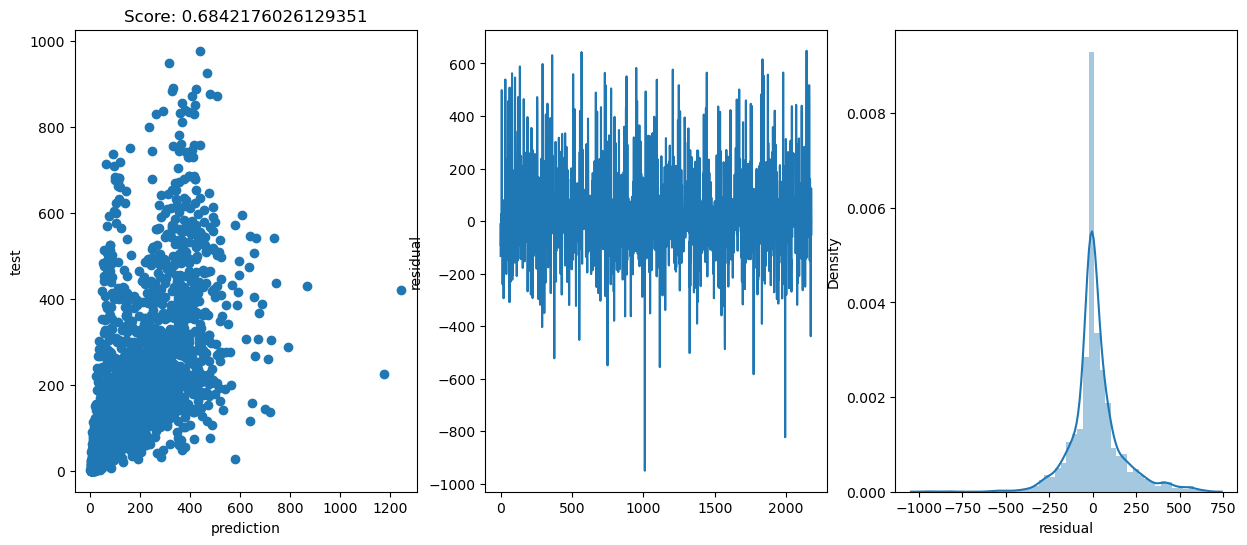

In [18]:
%%time 
columns_to_drop = "workingday atemp casual registered count".split()
fit_an_plot(df, columns_to_drop, "count", dgr=4, model=LinearRegression(), plotIt=True)

CPU times: user 1min 10s, sys: 200 ms, total: 1min 10s
Wall time: 1min 10s


0.7965593182636438

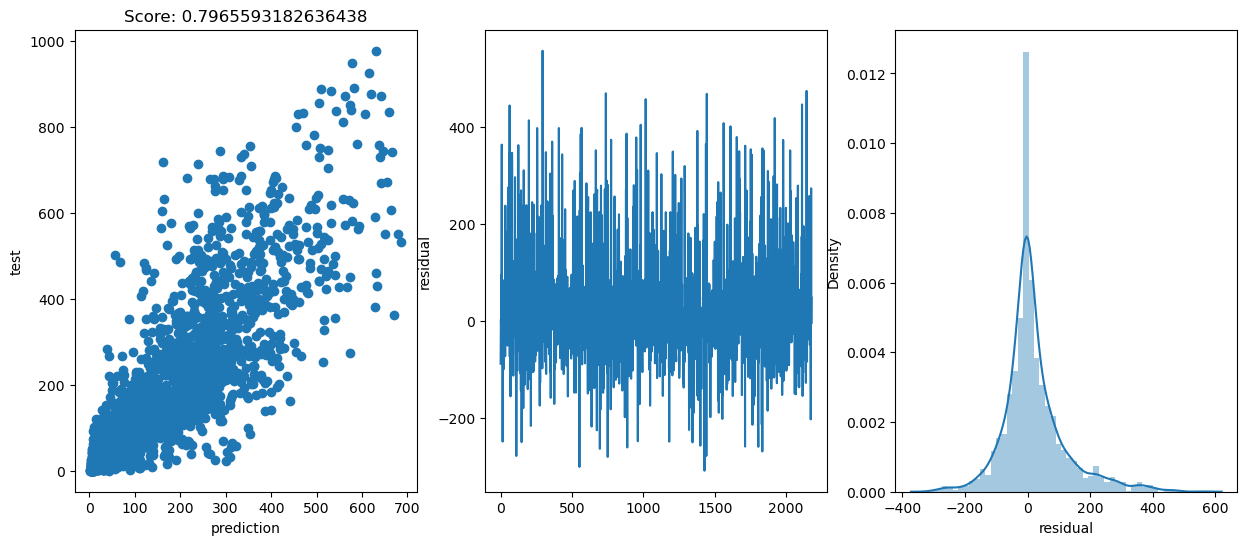

In [22]:
%%time 
columns_to_drop = "workingday atemp casual registered count".split()
fit_an_plot(df, columns_to_drop, "count", dgr=4, model=RandomForestRegressor(min_samples_split=3), plotIt=True)

# Build Estimator

In [26]:
class My_Estimator(BaseEstimator, TransformerMixin):

    def __init__(self, model, PolyExpansion):
        self.model = model
        self.poly = PolyExpansion
    
    def fit(self, X,y):
        y = np.log1p(y)
        X = self.poly.fit_transform(X)
        self.m = self.model.fit(X, y)

    def predict(self, X):
        prediction = self.m.predict(X)
        return np.exp(prediction)-1

    def score(self, X, y):
        y = np.log1p(y)
        X = self.poly.transform(X)
        return self.m.score(X, y)

In [28]:
columnsToDrop = "atemp casual registered count".split()
target_name = "count"
X_train, X_test, y_train, y_test = train_test_split(df.drop(columnsToDrop, axis=1), df[target_name], test_size=0.2, random_state=42)

estimator = My_Estimator(RandomForestRegressor(n_jobs=2), PolynomialFeatures(degree=4))
estimator.fit(X_train, y_train)
estimator.score(X_test, y_test)

0.9184520775454881

# HyperparametersOptimization

In [38]:
columns_to_drop = "holiday atemp casual registered count".split()

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns_to_drop, axis=1), 
    df["count"], test_size=0.2, random_state=42
    )

y_train, y_test = np.log1p(y_train), np.log1p(y_test)

colTransform = ColumnTransformer([
    ("Expansion", PolynomialFeatures(), X_train.columns)
    ])

pipe = Pipeline(steps=[
    ("Transform", colTransform),
    ("Model", RandomForestRegressor())
    ])

model_params = {
    'Transform__Expansion__degree': [4,5,6],
    'Model__min_samples_split': [2,3,5]
    }

gridsearch = GridSearchCV(pipe, model_params)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('Transform',
                                        ColumnTransformer(transformers=[('Expansion',
                                                                         PolynomialFeatures(),
                                                                         Index(['season', 'workingday', 'weather', 'temp', 'humidity', 'windspeed',
       'hour'],
      dtype='object'))])),
                                       ('Model', RandomForestRegressor())]),
             param_grid={'Model__min_samples_split': [2, 3, 5],
                         'Transform__Expansion__degree': [4, 5, 6]})

In [40]:
gridsearch.best_params_, gridsearch.best_score_

({'Model__min_samples_split': 5, 'Transform__Expansion__degree': 4},
 0.9159409650110995)

# Save / Load

In [41]:
joblib.dump(gridsearch, "RandomForest.pkl")

['RandomForest.pkl']

In [42]:
m = joblib.load("./RandomForest.pkl")
m.best_params_, m.best_score_

({'Model__min_samples_split': 5, 'Transform__Expansion__degree': 4},
 0.9159409650110995)